In [96]:
import numpy as np
import torch
from smplx import SMPLX
from os import path as osp
import copy
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("utils")
from mujoco_parser import MuJoCoParserClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

xml_path = 'asset/object/floor_sky.xml'
env = MuJoCoParserClass(name='',rel_xml_path=xml_path,VERBOSE=False)

MuJoCo version:[3.1.2]


In [97]:
motionx_dir = 'data/motion-x/data'
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Computation device: {}'.format(comp_device))

motionx_npy = osp.join(motionx_dir,'smplx','HAA500','subset_0008','Gangnam_Style_Dance_clip_12.npy')
# motionx_npy = osp.join(motionx_dir,'smplx','kungfu','subset_0000','Aerial_Kick_Kungfu_Wushu_clip_12.npy')
mdata = np.load(motionx_npy)

len = mdata.shape[0]
motion = torch.tensor(mdata).float()
motion_parms = {
            'root_orient': motion[:, :3].to(comp_device),  # controls the global root orientation
            'pose_body': motion[:, 3:3+63].to(comp_device),  # controls the body
            'pose_hand': motion[:, 66:66+90].to(comp_device),  # controls the finger articulation
            # 'pose_jaw': motion[:, 66+90:66+93].to(comp_device),  # controls the yaw pose
            # 'face_expr': motion[:, 159:159+50].to(comp_device),  # controls the face expression
            # 'face_shape': motion[:, 209:209+100].to(comp_device),  # controls the face shape
            'trans': motion[:, 309:309+3].to(comp_device),  # controls the global body position
            'betas': motion[:, 312:].to(comp_device),  # controls the body shape. Body shape is static
        }

print('Body parameter vector shapes: \n{}'.format(' \n'.join(['{}: {}'.format(k,v.shape) for k,v in motion_parms.items()])))

Computation device: cuda
Body parameter vector shapes: 
root_orient: torch.Size([193, 3]) 
pose_body: torch.Size([193, 63]) 
pose_hand: torch.Size([193, 90]) 
trans: torch.Size([193, 3]) 
betas: torch.Size([193, 10])


In [98]:
betas = motion_parms['betas']
body_pose = motion_parms['pose_body']
global_orient = motion_parms['root_orient']
left_hand_pose = motion_parms['pose_hand'][:, :45]
right_hand_pose = motion_parms['pose_hand'][:, 45:]
trans = motion_parms['trans']

model = SMPLX(model_path='smplx_models/male/model.npz', gender='male', num_betas=10, use_pca=False, flat_hand_mean=False).to(comp_device)
joints = []
for i in range(len):
    output = model(
        betas=betas[i].unsqueeze(0),
        body_pose=body_pose[i].unsqueeze(0),
        global_orient=global_orient[i].unsqueeze(0),
        transl=trans[i].unsqueeze(0)
    )
    joints.append(output.joints.detach().cpu().numpy().squeeze())

joint_positions = np.array(joints)
print(joint_positions.shape)

(193, 127, 3)


In [99]:
base = trans.cpu().numpy()
base = base[:,[2,0,1]]
base = np.repeat(base[:, np.newaxis, :], 55, axis=1)

array = joint_positions
body_hand_index = list(range(0,22)) + list(range(25,55))
array = array[:,body_hand_index,:]
array = array[:,:,[2,0,1]]
array -= array[0,0,:]
# array += base
array += [0,0,0.98]
joint_positions = array
print(joint_positions.shape)

(193, 52, 3)


In [100]:
body_connections = [
    [0, 1],   # Pelvis to left hip
    [0, 2],   # Pelvis to right hip
    [0, 3],   # Pelvis to spine1
    [3, 6],   # Spine1 to spine2
    [6, 9],   # Spine2 to spine3
    [9, 12],  # Spine3 to neck
    [12, 15], # Neck to head
    [9, 13],  # Spine3 to left collar
    [13, 16], # Left collar to left shoulder
    [16, 18], # Left shoulder to left elbow
    [18, 20], # Left elbow to left wrist
    [9, 14],  # Spine3 to right collar
    [14, 17], # Right collar to right shoulder
    [17, 19], # Right shoulder to right elbow
    [19, 21], # Right elbow to right wrist
    [1, 4],   # Left hip to left knee
    [4, 7],   # Left knee to left ankle
    [7, 10],  # Left ankle to left foot
    [2, 5],   # Right hip to right knee
    [5, 8],   # Right knee to right ankle
    [8, 11]   # Right ankle to right foot
]

# Hand joint connections (same for both hands)
left_hand_connections = [
    [20, 22],  [22, 23],  [23, 24],   # Index
    [20, 25],  [25, 26],  [26, 27],   # Middle
    [20, 28],  [28, 29],  [29, 30],   # Pinky
    [20, 31],  [31, 32],  [32, 33],   # Ring
    [20, 34],  [34, 35],  [35, 36],   # Thumb
]

right_hand_connections = [
    [21, 37],  [37, 38],  [38, 39],   # Index
    [21, 40],  [40, 41],  [41, 42],   # Middle
    [21, 43],  [43, 44],  [44, 45],   # Pinky
    [21, 46],  [46, 47],  [47, 48],   # Ring
    [21, 49],  [49, 50],  [50, 51],   # Thumb
]

# Combine body and hand connections
all_connections = body_connections.copy()

# Add left hand connections 
all_connections.extend(left_hand_connections.copy())

# Add right hand connections
all_connections.extend(right_hand_connections.copy())

all_connections  = np.array(all_connections)

In [101]:
import time
env.init_viewer(viewer_title='',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=2.6,elevation=-25,lookat=[0.0,0.0,0.83])
env.reset()

tick = 0
video = []

while tick < len and env.is_viewer_alive():
    
    joint_position = joint_positions[tick]

    for i in range(joint_position.shape[0]):
        env.plot_sphere(p=joint_position[i],r=0.01,rgba=[1,0,0,1])

    for j in range(np.shape(all_connections)[0]):
        a = all_connections[j][0]
        b = all_connections[j][1]
        env.plot_cylinder_fr2to(p_fr=joint_position[a],p_to=joint_position[b],r=0.003,rgba=[0.5,0.5,0.5,1])

    env.render()
    image = env.grab_image()
    video.append(image)
    if tick == len: tick = 0
    time.sleep(1/50)

env.close_viewer()

Pressed ESC
Quitting.


""

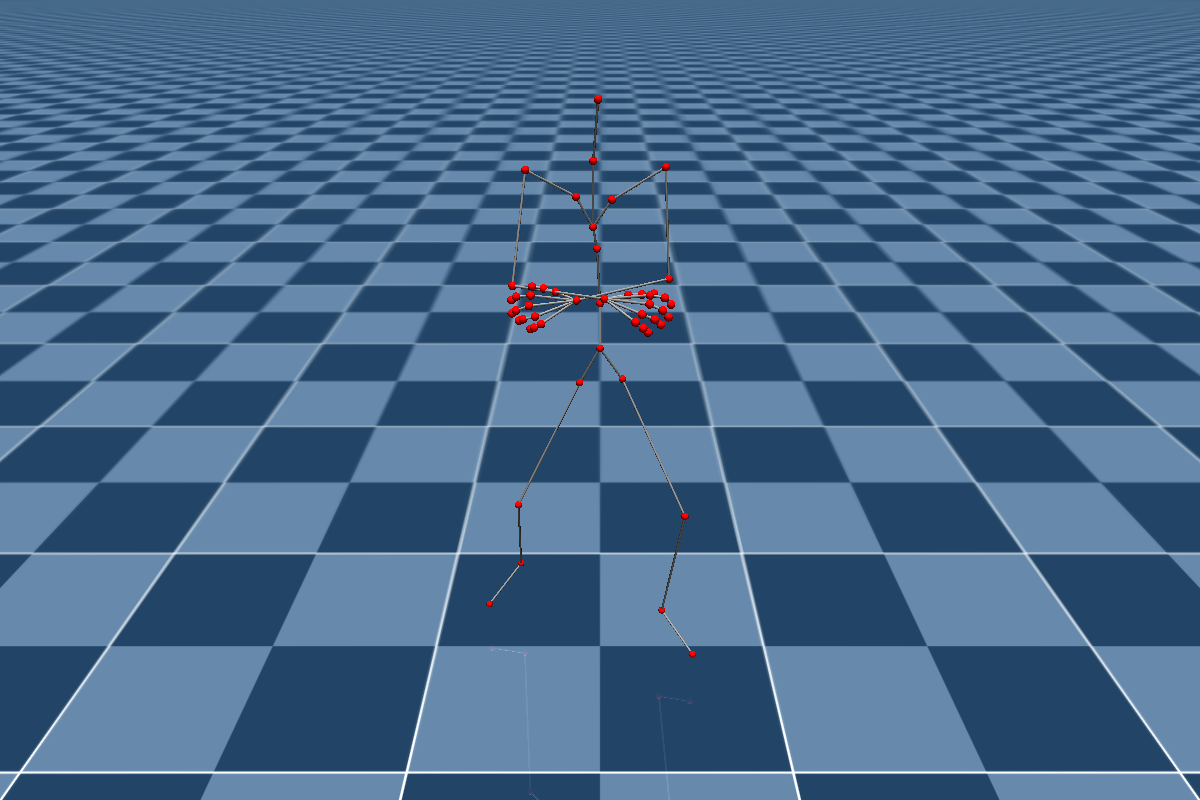

In [102]:
import mediapy
mediapy.show_image(video[0])